In [1]:
import json
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
folder = "one_targeted"
file_pattern = os.path.join(folder, "results_one_targeted_*.json")
json_files = glob.glob(file_pattern)[:10]  # Take first 10 files if more exist

print(f"Found {len(json_files)} files:")
for file in json_files:
    print(file)

Found 10 files:
one_targeted\results_one_targeted_20250724_202102.json
one_targeted\results_one_targeted_20250724_203027.json
one_targeted\results_one_targeted_20250724_203120.json
one_targeted\results_one_targeted_20250724_203142.json
one_targeted\results_one_targeted_20250724_203959.json
one_targeted\results_one_targeted_20250724_204253.json
one_targeted\results_one_targeted_20250724_204317.json
one_targeted\results_one_targeted_20250724_204341.json
one_targeted\results_one_targeted_20250724_204355.json
one_targeted\results_one_targeted_20250724_204410.json


In [4]:
# Initialize data structures
all_iterations = set()  # Initialize as a set
data_by_iteration = defaultdict(list)  # Dictionary to store data by iteration

# Read and process each JSON file
for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Extract metrics over time
    metrics = data['metrics_over_time']
    
    # Create a dictionary of this file's data by iteration
    file_data = {entry['iterations']: entry for entry in metrics}
    
    # Update the set of all iterations we've seen
    all_iterations.update(file_data.keys())
    
    # For each iteration in this file, store its data
    for iteration, entry in file_data.items():
        data_by_iteration[iteration].append({
            'noise': entry['noise_magnitude'],
            'current_boxes': entry['current_boxes'],
            'original_boxes': entry['original_boxes'],
            'percentage_increase': entry['percentage_increase']
        })

# Convert to sorted list of iterations
sorted_iterations = sorted(all_iterations)

In [5]:
# Calculate average values for each iteration across files
avg_data = []
for iteration in sorted_iterations:
    entries = data_by_iteration[iteration]
    
    # Only calculate average if we have data from multiple files
    if len(entries) > 1:
        avg_noise = np.mean([e['noise'] for e in entries])
        avg_current_boxes = np.mean([e['current_boxes'] for e in entries])
        avg_percentage = np.mean([e['percentage_increase'] for e in entries])
        
        # Original boxes should be the same across all entries
        original_boxes = entries[0]['original_boxes']
        
        avg_data.append({
            'iteration': iteration,
            'avg_noise': avg_noise,
            'avg_current_boxes': avg_current_boxes,
            'avg_percentage': avg_percentage,
            'original_boxes': original_boxes,
            'num_files': len(entries)  # Track how many files contributed to this average
        })
    

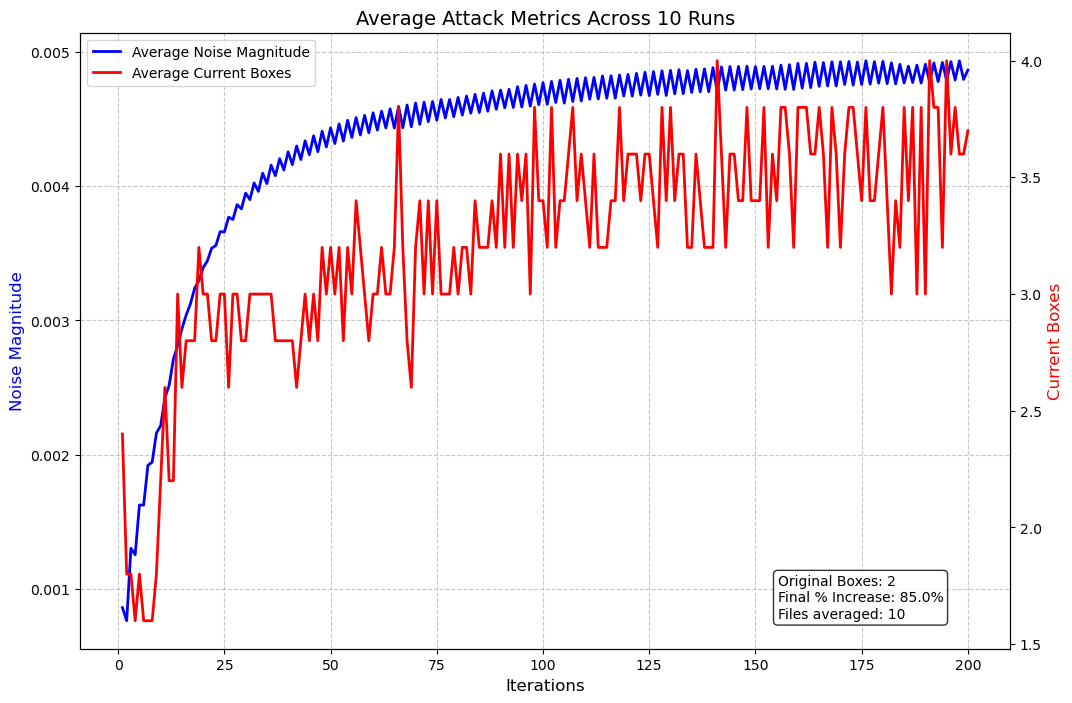

In [6]:
# Create the plot
plt.figure(figsize=(12, 8))

# Create primary axis for noise and current boxes
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot average noise
ax1.plot([d['iteration'] for d in avg_data],
         [d['avg_noise'] for d in avg_data],
         'b-', label='Average Noise Magnitude', linewidth=2)

# Plot average current boxes
ax2.plot([d['iteration'] for d in avg_data],
         [d['avg_current_boxes'] for d in avg_data],
         'r-', label='Average Current Boxes', linewidth=2)

# Set labels and colors
ax1.set_xlabel('Iterations', fontsize=12)
ax1.set_ylabel('Noise Magnitude', color='b', fontsize=12)
ax2.set_ylabel('Current Boxes', color='r', fontsize=12)

# Add title
plt.title(f'Average Attack Metrics Across {len(json_files)} Runs', fontsize=14)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)

# Add information box about original boxes and percentage increase
if avg_data:
    last_point = avg_data[-1]
    info_text = (f"Original Boxes: {last_point['original_boxes']}\n"
                 f"Final % Increase: {last_point['avg_percentage']:.1f}%\n"
                 f"Files averaged: {len(json_files)}")
    
    plt.annotate(info_text, xy=(0.75, 0.05), xycoords='axes fraction',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                 fontsize=10)
